<a href="https://colab.research.google.com/github/AleksandrRevuka/HW_Data_Science/blob/main/Hw9_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner
import tensorflow as tf
from sklearn.metrics import f1_score

from keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D
from keras.regularizers import l2, l1
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Nadam, Adamax, Ftrl
from keras.datasets import fashion_mnist

In [29]:
def plot_history(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    val_acc_values = history_dict['val_accuracy']

    epochs = range(1, len(history_dict['accuracy']) + 1)

    plt.style.use('ggplot')

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(linestyle='--')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.clf()
    plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
    plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(linestyle='--')
    plt.show()

In [30]:
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

train_data, test_data = train_data / 255., test_data / 255.

In [31]:
clothing_classes = 10
n_hidden_1 = 64
n_hidden_2 = 128
n_hidden_3 = 256
epochs = 10

In [32]:
def build_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(n_hidden_3, activation='relu'),
        Dense(n_hidden_2, activation='relu'),
        Dense(n_hidden_1, activation='relu'),
        Dense(clothing_classes, activation='softmax'),
    ])

    model.compile(
        optimizer=Adamax(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [33]:
model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               200960    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 10)                650       
                                                                 
Total params: 242762 (948.29 KB)
Trainable params: 242762 (948.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
history = model.fit(train_data, train_labels, epochs=epochs, validation_split=0.4, validation_data=(test_data, test_labels))


Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5160 - accuracy: 0.8193 - val_loss: 0.4376 - val_accuracy: 0.8454
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3837 - accuracy: 0.8629 - val_loss: 0.3896 - val_accuracy: 0.8623
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3426 - accuracy: 0.8751 - val_loss: 0.3839 - val_accuracy: 0.8616
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3178 - accuracy: 0.8838 - val_loss: 0.3944 - val_accuracy: 0.8599
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2974 - accuracy: 0.8916 - val_loss: 0.3407 - val_accuracy: 0.8782
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2832 - accuracy: 0.8965 - val_loss: 0.3366 - val_accuracy: 0.8769
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2701 - accuracy: 0.9004 - val_loss: 0.3429 - val_accuracy:

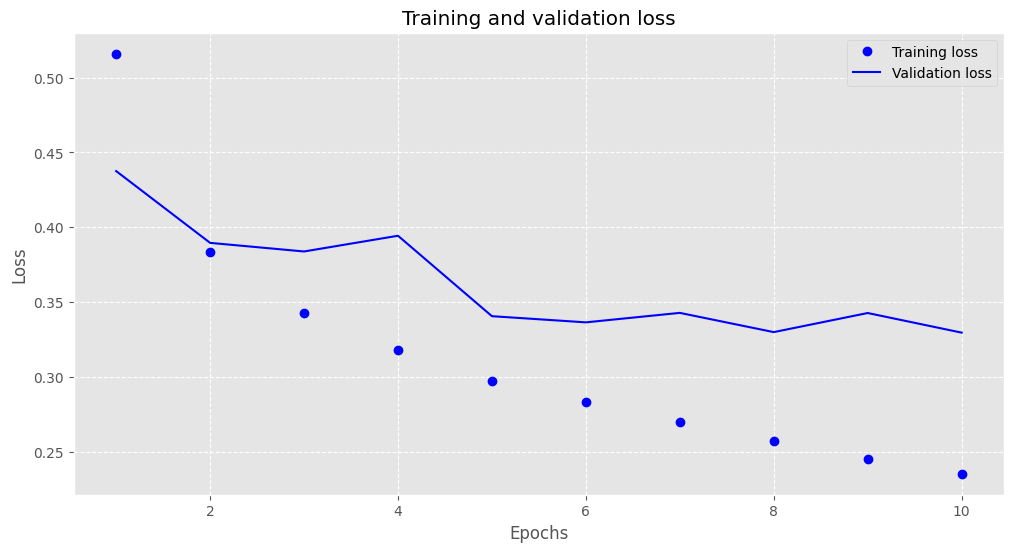

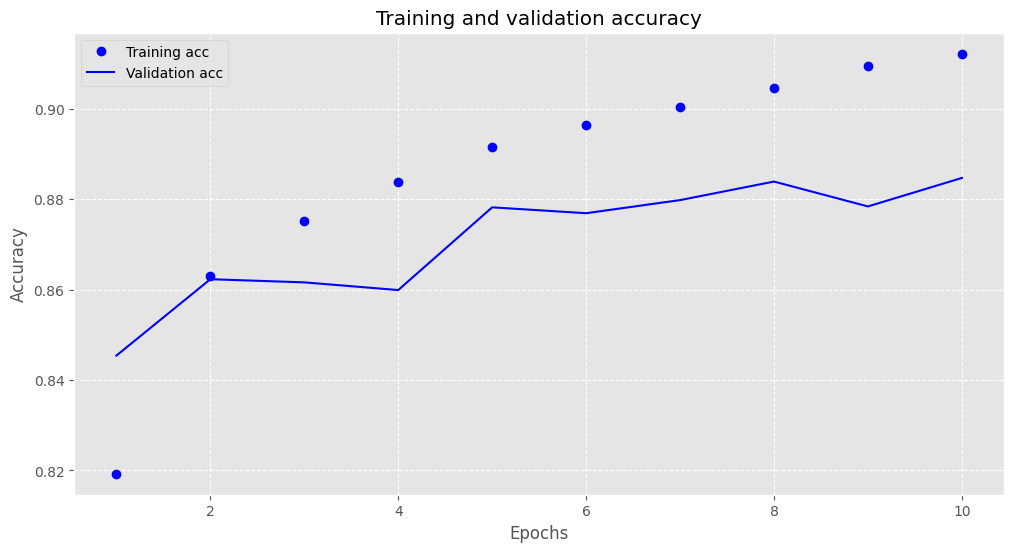

In [35]:
plot_history(history)

In [36]:
results = model.evaluate(test_data, test_labels)
print(results)

313/313 [==============================] - 0s 1ms/step - loss: 0.3297 - accuracy: 0.8847
[0.32968994975090027, 0.8847000002861023]


Вручну вдалося добитися accuracy: 0.8847 на валідаційних данних але не 0.91!

Автоматичний підбір гіперпараметрів:

In [37]:
def build_model_auto(hp):
    model = Sequential()
    model.add(Flatten())
    for i in range(hp.Int("num_layers", 2, 4)):
      model.add(
          Dense(
              units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
              activation="relu"
          )
      )

    if hp.Boolean("dropout"):
        model.add(Dropout(rate=0.25))
    model.add(Dense(10, activation="softmax"))

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [38]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model_auto,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
)


In [39]:
tuner.search(train_data, train_labels, epochs=10, validation_data=(test_data, test_labels))

Trial 5 Complete [00h 00m 50s]
val_accuracy: 0.8346999883651733

Best val_accuracy So Far: 0.8855999708175659
Total elapsed time: 00h 03m 53s


In [40]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
num_layers: 3
units_0: 512
units_1: 352
dropout: True
lr: 0.0005716024863895304
units_2: 128
units_3: 448
Score: 0.8855999708175659

Trial 3 summary
Hyperparameters:
num_layers: 3
units_0: 96
units_1: 128
dropout: True
lr: 0.00017951154199797646
units_2: 96
units_3: 416
Score: 0.8765000104904175

Trial 1 summary
Hyperparameters:
num_layers: 4
units_0: 32
units_1: 160
dropout: False
lr: 0.0004908089895878096
units_2: 32
units_3: 32
Score: 0.8741999864578247

Trial 0 summary
Hyperparameters:
num_layers: 2
units_0: 96
units_1: 32
dropout: True
lr: 0.002752738682669076
Score: 0.8698999881744385

Trial 4 summary
Hyperparameters:
num_layers: 4
units_0: 128
units_1: 320
dropout: True
lr: 0.006715083131370706
units_2: 192
units_3: 160
Score: 0.8346999883651733


In [41]:
models = tuner.get_best_models()
best_model = models[0]

best_model.build(input_shape=(None, 28, 28))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 352)               180576    
                                                                 
 dense_2 (Dense)             (None, 128)               45184     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 628970 (2.40 MB)
Trainable params: 628970 

In [42]:
results = best_model.evaluate(test_data, test_labels)
print(results)

313/313 [==============================] - 1s 1ms/step - loss: 0.3227 - accuracy: 0.8856
[0.32273468375205994, 0.8855999708175659]


Автоматично підбираючи кількість нейронів та шарів вдалося добитися accuracy: 0.88856 на валідаційних данних але не 0.91

In [43]:
def build_model_filter(hp):
  model = Sequential([
    Conv2D(
        filters=hp.Int('conv_1_filter', min_value=64, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(28,28,1)
    ),
    Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
    Flatten(),
    Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    Dense(10, activation='softmax')
  ])

  model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

In [44]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model_filter,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
)

In [45]:
tuner.search(train_data, train_labels, epochs=5, validation_data=(test_data, test_labels))

Trial 5 Complete [00h 07m 07s]
val_accuracy: 0.9139999747276306

Best val_accuracy So Far: 0.9139999747276306
Total elapsed time: 00h 31m 12s


In [46]:
models = tuner.get_best_models()
best_model = models[0]

best_model.build(input_shape=(None, 28, 28))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 96)        960       
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 48)        115248    
                                                                 
 flatten (Flatten)           (None, 23232)             0         
                                                                 
 dense (Dense)               (None, 64)                1486912   
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 1603770 (6.12 MB)
Trainable params: 1603770 (6.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
results = best_model.evaluate(test_data, test_labels)
print(results)

313/313 [==============================] - 4s 13ms/step - loss: 0.2917 - accuracy: 0.9140
[0.291700154542923, 0.9139999747276306]


Добавивши два шари Conv2D згорткової нейронної мережі з бібліотеки Keras. Цей шар ефективно працює з двовимірними даними, такими як чорно-білі або кольорові зображення. Мені вдалося досягти accuracy: 0.9140 на валідаційних данних.